<h1>Прогнозирование объемов потребления электроэнергии<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Используемые-ресурсы" data-toc-modified-id="Используемые-ресурсы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Используемые ресурсы</a></span></li><li><span><a href="#Создание-базы-данных" data-toc-modified-id="Создание-базы-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Создание базы данных</a></span><ul class="toc-item"><li><span><a href="#Сбор-данных-об-объемах-потребления" data-toc-modified-id="Сбор-данных-об-объемах-потребления-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Сбор данных об объемах потребления</a></span></li><li><span><a href="#Сбор-данных-о-погоде" data-toc-modified-id="Сбор-данных-о-погоде-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Сбор данных о погоде</a></span></li><li><span><a href="#Экспорт-итоговой-базы-данных" data-toc-modified-id="Экспорт-итоговой-базы-данных-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Экспорт итоговой базы данных</a></span></li></ul></li><li><span><a href="#Пополнение-базы-данных-оперативными-сведениями" data-toc-modified-id="Пополнение-базы-данных-оперативными-сведениями-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Пополнение базы данных оперативными сведениями</a></span></li><li><span><a href="#Подготовка-и-анализ-исходных-данных" data-toc-modified-id="Подготовка-и-анализ-исходных-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка и анализ исходных данных</a></span><ul class="toc-item"><li><span><a href="#Препроцессинг-генеральной-совокупности" data-toc-modified-id="Препроцессинг-генеральной-совокупности-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Препроцессинг генеральной совокупности</a></span></li><li><span><a href="#Корреляционная-матрица-признаков" data-toc-modified-id="Корреляционная-матрица-признаков-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Корреляционная матрица признаков</a></span></li><li><span><a href="#Оценка-ценности-признаков" data-toc-modified-id="Оценка-ценности-признаков-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Оценка ценности признаков</a></span></li></ul></li><li><span><a href="#Прогнозирование-энергопотребления" data-toc-modified-id="Прогнозирование-энергопотребления-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Прогнозирование энергопотребления</a></span></li><li><span><a href="#Экспресс-валидация" data-toc-modified-id="Экспресс-валидация-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Экспресс-валидация</a></span></li></ul></div>

**Исследуемый субъект:** республика Татарстан. Генеральная совокупность: 01.01.2013 – 01.06.2024, тестовая выборка: 2023 год (01.01.2023 – 31.12.2023), валидационная выборка: 01.06.2024 – 10.06.2024

# Используемые ресурсы

In [1]:
import os
import re
import locale
import requests
import warnings
from bs4 import BeautifulSoup
from tqdm.notebook import trange

import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost as xgb
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Создание базы данных
Запускается ежемесячно не позднее 7 числа после окончания расчётного периода для обновления БД<br>
Текущий интервал: 01.01.2013 – 01.06.2024

## Сбор данных об объемах потребления
Формирование базы данных из xls-файлов, предоставленных АО "Татэнергосыт" (*приложение 1*)

In [2]:
# получаем перечень всех папок из директории /_raw_Data_TatEnergosbyt
folders = list(folder for folder in os.listdir('_raw_Data_TatEnergosbyt'))

# получаем список месяцев на русском языке
locale.setlocale(locale.LC_TIME, 'ru_RU')
months = list(name.lower() for name in calendar.month_name if name != '')

# создаём датафрейм с данными об энергопотреблении
total_volume_df = pd.DataFrame()

# выгружаем данные из директории /_raw_Data_TatEnergosbyt
for folder in folders:
    for month in months:
                
        try:
            # получаем данные из единичного *.xls файла
            volume_df_raw = pd.read_excel(f'_raw_Data_TatEnergosbyt/{folder}/{month}.xls', index_col=0)

            # соединяем (горизонтально) две половины таблицы (верхнюю и нижнюю)
            volume_df_raw = pd.concat([volume_df_raw[6:6+24], volume_df_raw[-3-24:-3]], sort=False, axis=1)

            # удаляем "пустые" столбцы (заполненные NaN-ами)
            volume_df_raw.dropna(axis='columns', how='all', inplace=True)

            # в качестве имени столбцов назначаем порядковый номер дня месяца 
            volume_df_raw.columns = list(i for i in range(1, volume_df_raw.shape[1]+1))

            # сбрасываем индекс
            volume_df_raw.reset_index(drop=True, inplace=True)

            # создаём и заполняем фрагмент итоговой таблицы
            volume_df = pd.DataFrame(columns=['Date', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'Volume'])     

            volume_df.Volume = np.array([value for name, value in volume_df_raw.items()]).ravel()
            volume_df.Volume = volume_df.Volume.astype(float)
            volume_df.Day = pd.Series(list(i for i in range(1, volume_df_raw.shape[1] + 1) for _ in range(24)))
            volume_df.Hour = pd.Series(list(i for i in range(1, 25)) * volume_df_raw.shape[1])        
            volume_df.Month = months.index(month) + 1
            volume_df.Year = int(folder[:-1])

            # добавляем категориальный признак "день недели"
            volume_df.Date = pd.to_datetime(volume_df[['Year', 'Month', 'Day', 'Hour']])
            volume_df.Hour = volume_df.Date.dt.hour  # унифицируем 24-й час под DataTime-объект
            volume_df.Weekday = volume_df.Date.dt.weekday

            # сшиваем полученный фрагмент с итоговой таблицей
            total_volume_df = pd.concat([total_volume_df, volume_df])
        
        except FileNotFoundError:  # отрабатываем ситуацию неполного года
            continue
            
total_volume_df.to_excel('Volume.xlsx', index=False)  # экспорт датафрейма в xlsx-файл

In [3]:
total_volume_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100056 entries, 0 to 743
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Date     100056 non-null  datetime64[ns]
 1   Year     100056 non-null  int64         
 2   Month    100056 non-null  int64         
 3   Day      100056 non-null  int64         
 4   Hour     100056 non-null  int64         
 5   Weekday  100056 non-null  int64         
 6   Volume   100056 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 6.1 MB


In [4]:
total_volume_df

,Date,Year,Month,Day,Hour,Weekday,Volume
0,2013-01-01 01:00:00,2013,1,1,1,1,2033.264
1,2013-01-01 02:00:00,2013,1,1,2,1,1987.714
2,2013-01-01 03:00:00,2013,1,1,3,1,1955.861
3,2013-01-01 04:00:00,2013,1,1,4,1,1944.520
4,2013-01-01 05:00:00,2013,1,1,5,1,1964.332
...,...,...,...,...,...,...,...
739,2024-05-31 20:00:00,2024,5,31,20,4,2376.263
740,2024-05-31 21:00:00,2024,5,31,21,4,2396.689
741,2024-05-31 22:00:00,2024,5,31,22,4,2392.955
742,2024-05-31 23:00:00,2024,5,31,23,4,2268.094


## Сбор данных о погоде
Выгрузка базы данных о погоде в Татарстане с ноября 2010 года

In [5]:
# парсим данные из сайта kazan.nuipogoda.ru
links, data_of_weather = list(), list()

for month in months:
    req = requests.get(url=f'https://kazan.nuipogoda.ru/{month}-2013')
    soup = BeautifulSoup(req.content, 'lxml')
    all_tds = soup.find_all('td')
    for i in range(len(all_tds)):
        try:
            links.append('https://kazan.nuipogoda.ru/' + all_tds[i].find('a').get('href'))
        except AttributeError:
            continue

for link in links:
    req = requests.get(url=link)
    soup = BeautifulSoup(req.content)
    trs = soup.find_all('tr', time=re.compile(r'[0-9]'))
    for k in range(len(trs)):
        data_of_weather.append((list(trs[k].attrs.values())[0], trs[k].find('span', class_='ht').text[:-1]))

In [6]:
# Формируем датафрейм с погодными условиями
df_weather = pd.DataFrame(data_of_weather, columns=['Date', 'Temperature']).astype('int64')
df_weather.Date = pd.to_datetime(df_weather.Date, unit='ms')
df_weather = df_weather.drop_duplicates(subset=['Date'])
df_weather = df_weather.sort_values(by=['Date'])

df_weather.to_excel('Weather.xlsx', index=False)  # экспорт датафрейма в xlsx-файл

In [7]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41178 entries, 38177 to 46159
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         41178 non-null  datetime64[ns]
 1   Temperature  41178 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 965.1 KB


In [8]:
df_weather

,Date,Temperature
38177,2010-11-01 00:00:00,-2
38178,2010-11-01 03:00:00,0
38179,2010-11-01 06:00:00,-1
38180,2010-11-01 09:00:00,-1
38181,2010-11-01 12:00:00,1
...,...,...
46155,2024-12-31 12:00:00,-14
46156,2024-12-31 15:00:00,-13
46157,2024-12-31 18:00:00,-13
46158,2024-12-31 21:00:00,-12


## Экспорт итоговой базы данных

In [9]:
# для работы с готовыми фреймами расскоментируйте строки ниже
#total_volume_df = pd.read_excel('Volume.xlsx')
#df_weather = pd.read_excel('Weather.xlsx')

In [10]:
# объединяем полученные датафреймы по дате
df = total_volume_df.merge(df_weather, how='left', on = 'Date')

# интерполируем пропуски температуры (линейная, полиноминальная 3 порядка)
df[['Temperature']] = df[['Temperature']].interpolate(method='polynomial', order=3).round(1)

# экстраполируем пропуск температуры для первой записи соседним значением
df[['Temperature']] = df[['Temperature']].interpolate(method='nearest', axis=0).ffill().bfill()

# сохраняем полученную базу данных в xlsx-файл
df.to_excel('DataBase.xlsx', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100056 entries, 0 to 100055
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         100056 non-null  datetime64[ns]
 1   Year         100056 non-null  int64         
 2   Month        100056 non-null  int64         
 3   Day          100056 non-null  int64         
 4   Hour         100056 non-null  int64         
 5   Weekday      100056 non-null  int64         
 6   Volume       100056 non-null  float64       
 7   Temperature  100056 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 6.9 MB


In [11]:
df

,Date,Year,Month,Day,Hour,Weekday,Volume,Temperature
0,2013-01-01 01:00:00,2013,1,1,1,1,2033.264,-8.0
1,2013-01-01 02:00:00,2013,1,1,2,1,1987.714,-8.0
2,2013-01-01 03:00:00,2013,1,1,3,1,1955.861,-7.6
3,2013-01-01 04:00:00,2013,1,1,4,1,1944.520,-7.6
4,2013-01-01 05:00:00,2013,1,1,5,1,1964.332,-8.0
...,...,...,...,...,...,...,...,...
100051,2024-05-31 20:00:00,2024,5,31,20,4,2376.263,19.0
100052,2024-05-31 21:00:00,2024,5,31,21,4,2396.689,18.0
100053,2024-05-31 22:00:00,2024,5,31,22,4,2392.955,17.2
100054,2024-05-31 23:00:00,2024,5,31,23,4,2268.094,16.6


# Пополнение базы данных оперативными сведениями

Cоздание пустого датафрейма (25 строк: с 0:00 до 24:00) на указанную дату

In [12]:
def get_empty_daily_df(date):
    return pd.DataFrame(pd.date_range(date, periods=25, freq='H'), columns=['Date'])
    
#get_empty_daily_df(datetime(2024,6,5))

Пополнение датафрейма дополнительными (временными) категориальными признаками

In [13]:
def add_date_scalar(df):
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] =  df.Date.dt.day
    df['Hour'] = df.Date.dt.hour
    df['Hour'] = df['Hour']
    df['Weekday'] = df.Date.dt.weekday
    return df

#add_date_scalar(test_df)

Выгрузка архива/прогноза погоды на указанную дату

In [14]:
def get_weather(date):
    
    months = ['', 'января', 'февраля', 'марта', 'апреля', 'мая', 'июня', 
              'июля', 'августа', 'сентября', 'октября', 'ноября', 'декабря']  # названия месяцев в родительном падеже
    
    # выгружаем содержимое страницы https://kazan.nuipogoda.ru/ в переменную
    page = requests.get(url = f'https://kazan.nuipogoda.ru/{date.day}-{months[date.month]}#{date.year}')

    # сохраняем html-код страницы в переменную
    soup = BeautifulSoup(page.text, 'html.parser')
    
    # фильтруем теги с температурой
    trs = soup.find_all('tr', time=re.compile(r'[0-9]'))
    
    # получаем "сырые" данные
    day_weather_df = list()
    
    for tr in trs:
        day_weather_df.append((list(tr.attrs.values())[0], tr.find('span', class_='ht').text[:-1]))
        
    # формируем интерпретируемый датафрейм
    day_weather_df = pd.DataFrame(day_weather_df, columns=['Date', 'Temperature']).astype('int64')
    day_weather_df.Date = pd.to_datetime(day_weather_df.Date, unit='ms')
    day_weather_df = day_weather_df.sort_values(by=['Date'])
    day_weather_df = day_weather_df.tail(9)
    
    # интерполируем пропуски температуры (полиноминальная 3 порядка) между 0, 3, 6, 9, 12, 15, 18, 21 и 24 часами
    day_weather_df = get_empty_daily_df(date).merge(day_weather_df, how='left', on='Date')
    day_weather_df.Temperature = day_weather_df.Temperature.interpolate(method='polynomial', order=3).round(1)    
    
    return day_weather_df.tail(24)  # возвращаем погодный датафрейм с 1:00 до 24:00

#get_weather(datetime(2024,6,9))

Получение оперативных данных из директории `/_raw_Data_TatEnergosbyt` (*приложение 2*)

In [15]:
# получаем перечень всех файлов с оперативными данными из директории /_raw_Data_TatEnergosbyt
files = list(file for file in os.listdir(f'_raw_Data_TatEnergosbyt') if 'xlsx' in file)

# формируем датафрейм из этих файлов
total_oper_df = pd.DataFrame()

for file in files:    
    # получаем данные из единичного xlsx-файла
    oper_df = pd.read_excel(f'_raw_Data_TatEnergosbyt/{file}')
    oper_df.drop(oper_df.columns[[0, 3, 4, 5]], axis=1, inplace=True)
    oper_df.columns = ['Date', 'Volume']
    oper_df = oper_df[5:]
    oper_df.Volume = oper_df.Volume.astype(float)
    oper_df.Date = oper_df.Date.astype('datetime64[ns]')
    oper_df.Date = oper_df.Date.dt.floor('h')  # убираем "мусорные" микросекунды
    
    # пополняем датафрейм погодными условиями
    oper_df = oper_df.merge(get_weather(oper_df.iloc[0].Date.floor('d')), how='left', on='Date')
        
    # пополняем датафрейм дополнительными категориальными признаками
    oper_df = add_date_scalar(oper_df)
    
    # сшиваем данные из единичных xlsx-файлов
    total_oper_df = pd.concat([total_oper_df, oper_df])
    
    # удаляем прочтённый xlsx-файл (во избежание дублирования строк в БД)
    os.remove(f'_raw_Data_TatEnergosbyt/{file}')
    
total_oper_df

,Date,Volume,Temperature,Year,Month,Day,Hour,Weekday
0,2024-06-01 01:00:00,2015.786000,14.7,2024,6,1,1,5
1,2024-06-01 02:00:00,1974.203000,14.4,2024,6,1,2,5
2,2024-06-01 03:00:00,1924.646000,15.0,2024,6,1,3,5
3,2024-06-01 04:00:00,1888.457000,16.1,2024,6,1,4,5
4,2024-06-01 05:00:00,1893.005000,17.5,2024,6,1,5,5
...,...,...,...,...,...,...,...,...
19,2024-06-09 20:00:00,2272.555436,21.8,2024,6,9,20,6
20,2024-06-09 21:00:00,2312.999271,20.0,2024,6,9,21,6
21,2024-06-09 22:00:00,2328.215377,18.2,2024,6,9,22,6
22,2024-06-09 23:00:00,2213.078977,16.7,2024,6,9,23,6


In [16]:
if total_oper_df.shape[0]:    
    
    # добавляем полученные данные к общей базе
    df = pd.read_excel('DataBase.xlsx')
    df = pd.concat([df, total_oper_df])

    # обновляем xlsx-файл с БД
    df.to_excel('DataBase.xlsx', index=False)

# Подготовка и анализ исходных данных

## Препроцессинг генеральной совокупности

In [17]:
# для работы с готовой БД раскомментируйте строку ниже 
#df = pd.read_excel('DataBase.xlsx')

In [18]:
def prepareData(df, lag_start=1, lag_end=7):        
    
    # добавляем суточные лаги исходного ряда (по умолчанию 1 полная неделя)
    for i in range(lag_start, lag_end + 1):    
        df[f"lag-{i}"] = df.Volume.shift(i*24)   

    # удаляем первые 24*(lag_start – lag_end) записей с пропусками данных (168 записей для лага в 7 суток)
    df = df.dropna(subset=['lag-1', 'lag-2', 'lag-3', 'lag-4', 'lag-5', 'lag-6', 'lag-7'])
    df.reset_index(drop=True, inplace=True)
    
    return df

In [19]:
# формируем генеральную совокупность
df_general = df.copy()

# добавляем новые признаки
df_general = prepareData(df_general)
df_general.iloc[:, 1:]

,Year,Month,Day,Hour,Weekday,Volume,Temperature,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7
0,2013,1,8,1,1,2017.102000,-6.1,1983.630000,1984.007000,2000.216000,1972.473000,2008.811000,2027.193000,2033.264
1,2013,1,8,2,1,1964.942000,-6.0,1932.213000,1934.204000,1950.523000,1920.304000,1953.228000,1970.887000,1987.714
2,2013,1,8,3,1,1938.221000,-6.0,1904.510000,1907.831000,1920.106000,1889.606000,1915.720000,1938.669000,1955.861
3,2013,1,8,4,1,1929.957000,-6.0,1895.918000,1897.508000,1915.331000,1882.192000,1904.349000,1931.414000,1944.520
4,2013,1,8,5,1,1950.473000,-6.0,1921.034000,1904.977000,1922.729000,1902.160000,1905.641000,1939.466000,1964.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100099,2024,6,9,20,6,2272.555436,21.8,2271.011250,2386.182736,2421.378673,2415.583867,2401.514952,2467.779016,2334.364
100100,2024,6,9,21,6,2312.999271,20.0,2286.499684,2394.617812,2430.455592,2436.232011,2412.605402,2469.398816,2354.693
100101,2024,6,9,22,6,2328.215377,18.2,2302.465685,2420.358483,2438.924052,2430.614426,2416.142478,2490.485832,2366.600
100102,2024,6,9,23,6,2213.078977,16.7,2199.071768,2296.690451,2302.028551,2270.017769,2274.016779,2343.036600,2239.832


## Корреляционная матрица признаков
Опциальный пункт (можно пропустить)

[Text(0.5, 1.0, 'Correlation matrix of initial features')]

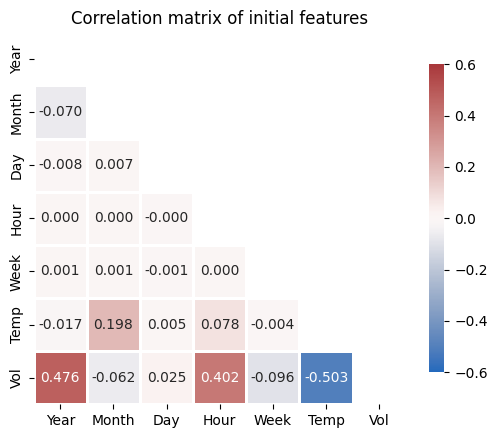

In [20]:
# корреляция исходных значений и целевого признака
color_map = sns.color_palette("vlag", as_cmap=True)

df_gen = df_general[['Year', 'Month', 'Day', 'Hour', 'Weekday', 'Temperature', 'Volume']]
df_gen = df_gen.rename(columns={'Weekday': 'Week', 'Temperature': 'Temp', 'Volume': 'Vol'})

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_gen.corr(), dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 5))

plt.rcParams.update({'font.size': 10, 'font.serif': 'Times New Roman'})

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_gen.corr(), annot=True, mask=mask, cmap=color_map, fmt=".3f", vmax=.6, vmin=-0.6, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .8}).set(title='Correlation matrix of initial features')

#print(plt.rcParams)  # полный перечень всех настроек plt.rcParams
#df_gen.corr('pearson').style.background_gradient(cmap=color_map, vmin = -1, vmax=1)  # вывод в форме компактной таблицы

**Вывод**: ощутимая корреляционная связь объема с годом, часом и температурой

## Оценка ценности признаков
Опциальный пункт (можно пропустить)

In [21]:
# классификация ценности признаков в контексте регрессора XGBoost
selector = xgb.XGBRegressor(random_state=10)
result = selector.fit(df_general.drop(columns=['Date', 'Volume']), df_general['Volume'])

features_table = pd.DataFrame(result.feature_importances_, 
                              index = df_general.drop(columns=['Date', 'Volume']).columns, 
                              columns = ['importance'])

features_table = features_table.sort_values(by='importance', ascending=False).T
features_table

,lag-1,lag-7,Weekday,lag-3,lag-6,Month,Hour,Temperature,Day,Year,lag-4,lag-5,lag-2
importance,0.794987,0.158203,0.013801,0.006593,0.00466,0.004293,0.00412,0.003703,0.003214,0.002127,0.00211,0.001247,0.000942


# Прогнозирование энергопотребления

Функция поиска оптимальных гиперпараметров модели (период обучения, глубина дерева)

In [22]:
def search_HP(df_general):
    df_params_search = pd.DataFrame({'period':[],         # оптимальный период обучения
                                     'MAE [MW]':[],       # минимальная средняя абсолютная ошибка
                                     'MAPE':[],           # минимальная средняя относительная ошибка
                                     'max_depth':[],      # оптимальная глубина дерева
                                     'n_estimators':[]})  # оптимальное количество деревьев

    # формируем тестовую выборку (-1 год от текущих суток)
    df_fresh_test = df_general[df_general.Date > datetime.now().replace(year=datetime.now().year-1, hour = 0)]
       
    index = 0  # индекс узла сетки итогового датафрейма

    for period in range(4, 9):

        # вычитаем из текущей даты заданный период (от 4 до 9 лет)
        df_train = df_general[df_general.Date > datetime.now().replace(year=datetime.now().year-period, hour = 0)]
        
        # откатываем содержимое df_test к исходному состоянию
        df_test = df_fresh_test.copy()

        XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100),
                                  param_grid={'max_depth': range(2, 6)},
                                  scoring='neg_mean_absolute_percentage_error',
                                  verbose = 0,
                                  cv=5)

        XGB_search.fit(df_train.drop(columns=['Date', 'Volume']), df_train['Volume'].values)

        XGB_best = XGB_search.best_estimator_

        XGB_best.fit(df_train.drop(columns=['Date', 'Volume']), df_train['Volume'].values)

        df_test['Predicted'] = XGB_best.predict(df_test.drop(columns=['Date', 'Volume']))

        hyper_params = XGB_best.get_params()

        # заполняем итоговый датафрейм лучшим результатом для данной выборки
        df_params_search.loc[index] = (period,
                                       MAE(df_test['Predicted'], df_test['Volume']), 
                                       MAPE(df_test['Predicted'], df_test['Volume']),
                                       hyper_params['max_depth'],
                                       hyper_params['n_estimators'])
        index += 1;

    i = df_params_search.MAPE.idxmin()  # позиция df_params_search с лучшим результатом

    best_HP = {'period': df_params_search.period[i].astype(int),   # оптимальный временной период
               'max_depth': df_params_search.max_depth[i].astype(int),   # отпимальная глубина дерева
               'n_estimators': df_params_search.n_estimators[i].astype(int)}  # оптимальное количество деревьев

    return best_HP

# example:
#search_HP(df_general, df_test)

Функция обучения модели и прогнозирования объемов энергопотребления

In [23]:
def predict_volume(df_general, df_predict, best_HP):

    # формируем оптимальную обучающую выборку
    df_train = df_general[df_general.Date > datetime.now().replace(year=datetime.now().year-best_HP['period'], hour = 0)]

    # обучаем модель
    model = xgb.XGBRegressor(tree_method = 'gpu_hist', # включаем ранее найденные оптимальные гиперпараметры 
                             n_estimators = int(best_HP['n_estimators']),
                             max_depth = int(best_HP['max_depth']))

    model.fit(df_train.drop(columns=['Date', 'Volume']), df_train['Volume'])

    # прогнозируем объёмы потребления на ближайшие сутки
    df_predict['Volume'] = model.predict(df_predict.drop(columns=['Date', 'Volume']))
   
    return df_predict

Функция генерации датафрейма с прогнозными объёмами энергопотребления под указанный горизонт планирования

In [24]:
# определяем горизонт планирования (по умолчанию – на сутки вперёд от текущей даты)
def get_df_predicted(df_general,
                     date_start = datetime.now().date(), 
                     date_end = datetime.now().date() + timedelta(days=1)):
    
    '''
    SYNOPSYS: Функция генерации датафрейма с прогнозными объёмами энергопотребления под указанный горизонт планирования

    KEYWORD ARGUMENTS:
    df_general -- актуальная генеральная совокупность ко дню прогноза
    date_start -- дата от начала старта прогноза (по умолчанию – текущий день)
    date_end -- дата окончания прогноза (по умолчанию – сутки вперёд)

    EXAMPLE:
    # генерация прогнозных объемов потребления ЭЭ на сутки вперед
    get_df_predicted(df_general)

    # генерация прогнозных объемов потребления ЭЭ от указанной даты на сутки вперед
    get_df_predicted(df_general, date_start=datetime(2024, 5, 12).date())

    # генерация прогнозных объемов потребления ЭЭ от текущего дня до указанной даты
    get_df_predicted(df_general, date_end=datetime(2024, 6, 15).date())

    # генерация прогнозных объемов потребления ЭЭ от одной до другой указанной даты
    get_df_predicted(df_general, date_start=datetime(2024, 5, 14).date(), date_end=datetime(2024, 5, 16).date())
    '''
    
    # генерируем пустой датафрейм под итоговый результат
    df_predicted = pd.DataFrame()
    
    for date in trange((date_end - date_start).days + 1, desc=f"days progress"):  # виджет процесса расчёта по суткам
    
        # генерируем пустой суточный датафрейм с погодными и календарными признаками
        df_predicted_daily = add_date_scalar(get_weather(date_start + timedelta(days=date)))

        # добавляем последние 168 (24 · 7) строк от df_general для генерации временного лага
        df_predicted_daily = pd.concat([df_general.tail(168), df_predicted_daily])  
        df_predicted_daily = df_predicted_daily[['Date', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'Volume', 'Temperature']]

        # генерируем временной лаг (1 полная неделя)
        df_predicted_daily = prepareData(df_predicted_daily)

        # определяем лучшие гиперпараметры модели для текущей генеральной совокупности
        best_HP = search_HP(df_general)

        # получаем прогнозные значения на текущие сутки используя ранее найденные гиперпараметры
        df_predicted_daily = predict_volume(df_general, df_predicted_daily, best_HP)

        # добавляем полученные прогнозные значения в итоговый прогнозный фрейм
        df_predicted = pd.concat([df_predicted, df_predicted_daily])

        # пополняем генеральную совокупность текущими сутками (+24 строки) для планирования следующего дня
        df_general = pd.concat([df_general, df_predicted_daily])

    df_predicted.rename(columns = {'Volume':'Predicted'}, inplace = True)
    
    return df_predicted[['Date', 'Predicted']]

In [25]:
%%time

df_predicted = get_df_predicted(df_general, date_start=datetime(2024, 6, 10).date(), date_end=datetime(2024, 6, 10).date())
df_predicted.to_excel('Predicted.xlsx', index=False)

days progress:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 2min 43s
Wall time: 36.6 s


# Экспресс-валидация

In [26]:
# получаем перечень всех файлов с оперативными данными из директории /_raw_Data_TatEnergosbyt
files = list(file for file in os.listdir(f'_raw_Data_TatEnergosbyt') if 'xlsx' in file)

# формируем датафрейм из этих файлов
total_oper_df = pd.DataFrame()

for file in files:    
    # получаем данные из единичного xlsx-файла
    oper_df = pd.read_excel(f'_raw_Data_TatEnergosbyt/{file}')
    oper_df.drop(oper_df.columns[[0, 3, 4, 5]], axis=1, inplace=True)
    oper_df.columns = ['Date', 'Volume']
    oper_df = oper_df[5:]
    oper_df.Volume = oper_df.Volume.astype(float)
    oper_df.Date = oper_df.Date.astype('datetime64[ns]')
    oper_df.Date = oper_df.Date.dt.floor('h')  # убираем "мусорные" микросекунды
    
    # пополняем датафрейм погодными условиями
    oper_df = oper_df.merge(get_weather(oper_df.iloc[0].Date.floor('d')), how='left', on='Date')
        
    # пополняем датафрейм дополнительными категориальными признаками
    oper_df = add_date_scalar(oper_df)
    
    # сшиваем данные из единичных xlsx-файлов
    total_oper_df = pd.concat([total_oper_df, oper_df])
    
    # удаляем прочтённый xlsx-файл (во избежание дублирования строк в БД)
    
#total_oper_df

In [27]:
# Метрики качества прогноза
print('MAE:', f"{MAE(df_predicted['Predicted'], total_oper_df['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_predicted['Predicted'], total_oper_df['Volume']):.2%}")

MAE: 24.38 [MW] 
MAPE: 1.11%


In [28]:
def diff_predict_vs_fact(df_predicted):

    df_validate_graph = df_predicted.copy()
    
    # добавление новых столбцов (для расчёта усреднённой погрешности)
    df_validate_graph.insert(df_validate_graph.shape[1], 'MAPE', 
                             MAPE(df_validate_graph['Predicted'], df_validate_graph['Volume'])*100)

    df_validate_graph['Error'] = abs((df_validate_graph['Volume'] - df_validate_graph['Predicted'])*100
                                 /df_validate_graph['Volume'])

    df_validate_graph.reset_index(drop=True, inplace=True)

    fig, df_volume = plt.subplots(figsize=(16,5))
    df_error = df_volume.twinx()

    df_volume.plot(df_validate_graph['Volume'], label='Actual value')
    df_volume.plot(df_validate_graph['Predicted'], label='Predicted value')
    df_error.plot(df_validate_graph['Error'], label='Error, %', color='#2ca02c')
    df_error.plot(df_validate_graph['MAPE'], '-.b')

    plt.rcParams['font.size'] = '12'

    df_volume.legend(loc='upper right')
    df_volume.set_xlim(0, df_validate_graph.shape[0])
    df_volume.set_ylim(df_validate_graph.Volume.min() - 100, df_validate_graph.Volume.max() + 100)
    df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
    df_volume.set_xlabel('Counts of records', fontsize = 14)

    df_error.set_ylim(0, 10)
    df_error.set_ylabel('Absolute percentage error, %', fontsize = 14, color='g')

    plt.title(f'The segment of the model testing process ({(df_predicted.Date[0]).date()} – {(df_predicted.Date[df_predicted.shape[0]-1]).date()})', 
              fontsize = 16)
    print(f"MAPE: {round(df_validate_graph['MAPE'].iloc[0], 3)}%")

MAPE: 1.113%


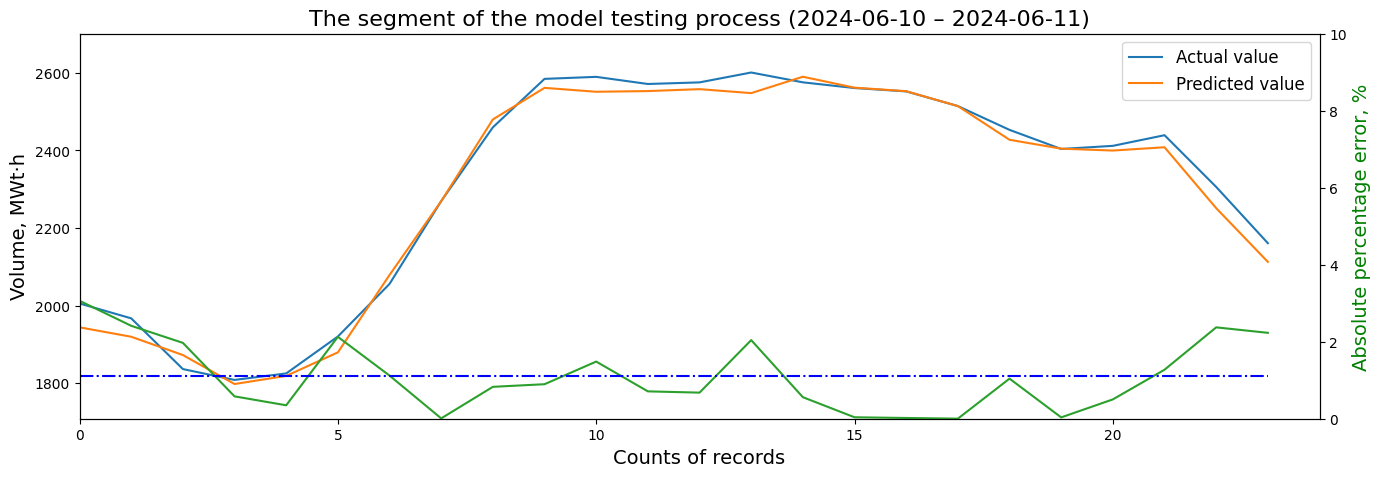

In [30]:
df_predicted['Volume'] = total_oper_df['Volume']
diff_predict_vs_fact(df_predicted)